#0. Prerequisites

### 0.1 Library Loading and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tensorflow as tf
import pathlib
import os
import random

### 0.2 Importing the Dataset

In [2]:
source_url = 'https://github.com/subtle64/Datasets/raw/main/Kaggle/hymenoptera_data.zip'
data_url = pathlib.Path(tf.keras.utils.get_file(origin = source_url, extract = True)).with_suffix('')
print(data_url)

47268762/47268762 [==============================] - 1s 0us/step
/root/.keras/datasets/hymenoptera_data


In [3]:
os.listdir(data_url)

['train', 'val']

In [4]:
#Fix one file with the wrong extension format, .jpeg is equivalent to .jpg
#Fix one errenous .gif file containing a placeholder
f1 = f"{data_url}/train/ants/formica.jpeg"
f2 = f"{data_url}/train/ants/imageNotFound.gif"

if (os.path.isfile(f1)):
  os.rename(f"{data_url}/train/ants/formica.jpeg", f"{data_url}/train/ants/formica.jpg")

if (os.path.isfile(f2)):
  os.remove(f"{data_url}/train/ants/imageNotFound.gif")

In [5]:
#Check the number of data we have:
dir_images = list(data_url.rglob('*.jpg'))
dir_train = list(data_url.rglob('train/*/*.jpg'))
dir_val = list(data_url.rglob('val/*/*.jpg'))
print(f"Total images: {len(dir_images)}")
print(f"Total training data: {len(dir_train)}")
print(f"Total validation data: {len(dir_val)}")

#In the folder of data, there are 2 images in format .jpeg and .gif, both of which
#are unsuitable for training since the .gif image is a placeholder image and

Total images: 397
Total training data: 244
Total validation data: 153


In [6]:
#Splitting the images to their respective classes
ants = list(data_url.rglob('ants/*.jpg'))
bees = list(data_url.rglob('bees/*.jpg'))
print(f"Number of ants: {len(ants)}")
print(f"Number of bees: {len(bees)}")

Number of ants: 193
Number of bees: 204


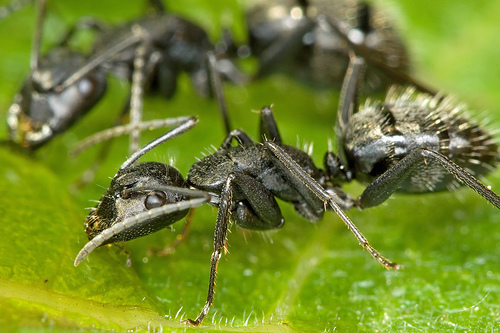

In [7]:
#Take a random ant image from the list of data
PIL.Image.open(ants[random.randint(0, len(ants) - 1)])

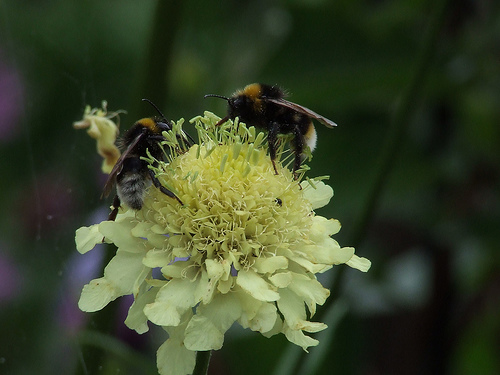

In [8]:
#Take a random bee image from the list of data
PIL.Image.open(bees[random.randint(0, len(bees) - 1)])

###0.3 Image Equalization

In [9]:
#Overwrite and fix contrast
import skimage as ski
for file in dir_images:
  img = ski.io.imread(file)
  img_equalized = ski.exposure.equalize_adapthist(img, kernel_size=None, clip_limit=0.01, nbins=256)
  plt.imsave(file, img_equalized)

#1. Modelling using a basic CNN

###1.1 Dataset Creation

In [10]:
img_sizes = np.array([PIL.Image.open(file).size for file in dir_images])
print(f"Minimum width: {np.argmin(img_sizes[:, 0])}")
print(f"Minimum height: {np.argmin(img_sizes[:, 1])}")

Minimum width: 67
Minimum height: 67


In [11]:
BATCH_SIZE = 16
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [12]:
ds_train = tf.keras.utils.image_dataset_from_directory(
  str(data_url) + '/train',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  crop_to_aspect_ratio=True,
  batch_size=BATCH_SIZE)

Found 244 files belonging to 2 classes.


In [13]:
ds_val = tf.keras.utils.image_dataset_from_directory(
  str(data_url) + '/val',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  crop_to_aspect_ratio=True,
  batch_size=BATCH_SIZE)

Found 153 files belonging to 2 classes.


In [14]:
y_classes = ds_train.class_names
print(y_classes)

['ants', 'bees']


In [15]:
#Shuffle and optimize
ds_train = ds_train.cache().shuffle(1).prefetch(buffer_size= tf.data.AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

###1.2 Creating the Model

In [16]:
from tensorflow import keras
from keras import layers

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

#Defining the model
inputs = keras.Input(input_shape)

#Augment the data
random_flip = layers.RandomFlip(seed = 1, input_shape = input_shape)(inputs)
random_rotation = layers.RandomRotation(0.3, seed = 1)(random_flip)
random_zoom = layers.RandomZoom(0.2, seed = 1)(random_rotation)

#The Model Itself
conv2D_1 = layers.Conv2D(32, 2, padding = "same", activation = "relu")(random_zoom)
maxPool_1 = layers.MaxPool2D()(conv2D_1)

conv2D_2 = layers.Conv2D(128, 8, padding = "same", activation = "relu")(maxPool_1)
maxPool_2 = layers.MaxPool2D()(conv2D_2)

conv2D_3 = layers.Conv2D(64, 4, padding = "same", activation = "relu")(maxPool_2)
maxPool_3 = layers.MaxPool2D()(conv2D_3)

dropout_1 = layers.Dropout(0.2)(maxPool_3)

conv2D_4 = layers.Conv2D(256, 16, padding = "same", activation = "relu")(dropout_1)
maxPool_4 = layers.MaxPool2D()(conv2D_4)

dropout_2 = layers.Dropout(0.1)(maxPool_4)

flatten = layers.Flatten()(dropout_2)
denseHead = layers.Dense(256, activation = "relu")(flatten)
outputs = layers.Dense(1, activation = "sigmoid")(denseHead)

basic_cnn = keras.Model(inputs, outputs)

In [17]:
basic_cnn.compile(optimizer = 'adam', loss=keras.losses.binary_crossentropy, metrics = ['binary_accuracy'])
basic_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                          

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'loss',
        patience = 25,
        verbose = 1,
        restore_best_weights = True
    )
]

In [19]:
basic_cnn_results = basic_cnn.fit(
    ds_train,
    validation_data=ds_val,
    epochs = 100,
    callbacks = callbacks
)

Epoch 1/100
16/16 [==============================] - 22s 403ms/step - loss: 485.9142 - binary_accuracy: 0.5287 - val_loss: 0.6928 - val_binary_accuracy: 0.5425
Epoch 2/100
16/16 [==============================] - 2s 140ms/step - loss: 0.7566 - binary_accuracy: 0.5615 - val_loss: 0.7185 - val_binary_accuracy: 0.4967
Epoch 3/100
16/16 [==============================] - 2s 135ms/step - loss: 0.9296 - binary_accuracy: 0.5369 - val_loss: 0.6938 - val_binary_accuracy: 0.4575
Epoch 4/100
16/16 [==============================] - 2s 135ms/step - loss: 0.7690 - binary_accuracy: 0.5082 - val_loss: 0.6942 - val_binary_accuracy: 0.4575
Epoch 5/100
16/16 [==============================] - 2s 142ms/step - loss: 0.6899 - binary_accuracy: 0.5041 - val_loss: 0.6956 - val_binary_accuracy: 0.4575
Epoch 6/100
16/16 [==============================] - 2s 138ms/step - loss: 0.6922 - binary_accuracy: 0.5041 - val_loss: 0.6948 - val_binary_accuracy: 0.4575
Epoch 7/100
16/16 [==============================] - 2s

<Axes: >

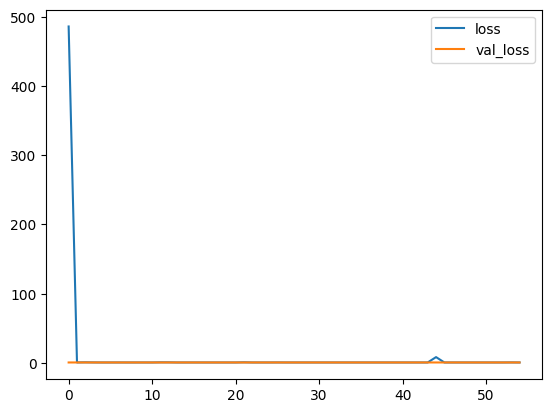

In [20]:
#Terrible results, the data is too small, and the model is too simple
train_results = pd.DataFrame(basic_cnn_results.history)
train_results.loc[:, ['loss', 'val_loss']].plot()

The model is incapable of learning the information provided. 
There are some mistakes I found when I trained:
1. EarlyStopping() *should* monitor 'val_loss' just realized that right now :)
2. The results are really bad, the model structure is uncapable of learning the dataset, possibly due to wrong use of regularization techniques, I should try a simpler CNN model, not this deep, and start with no regularization steps. Hey, overfitting is still better than 0.48 accuracy.

#2. Transfer Learning

###2.1 VGG16 Model

In [21]:
#Let us use the pretrained model VGG16 and do transfer learning on our dataset
vgg16_model = keras.applications.VGG16(
    weights = 'imagenet',
    input_shape = (256, 256, 3),
    include_top = False
)

vgg16_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [22]:
#Creating a new model as the new top
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
inputs = keras.Input(input_shape)
random_flip = layers.RandomFlip(seed = 1, input_shape = input_shape)(inputs)
random_rotation = layers.RandomRotation(0.3, seed = 1)(random_flip)
random_zoom = layers.RandomZoom(0.2, seed = 1)(random_rotation)
random_brightness = layers.RandomBrightness(0.1, seed = 1)(random_zoom)
noise = layers.GaussianNoise(seed = 1, stddev = 0.3)(random_brightness)

base = vgg16_model(noise, training=False)
pool2D = layers.GlobalAveragePooling2D()(base)
dropout = layers.Dropout(0.5)(pool2D)
outputs = layers.Dense(1)(pool2D)

transfer_model = keras.Model(inputs, outputs)

In [23]:
transfer_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0005), loss=keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['binary_accuracy'])
transfer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 256, 256, 3)       0         
 rightness)                                                      
                                                                 
 gaussian_noise (GaussianNo  (None, 256, 256, 3)       0   

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'loss',
        patience = 25,
        verbose = 1,
        restore_best_weights = True
    )
]

In [25]:
transfer_results = transfer_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs = 300,
    callbacks = callbacks
)

Epoch 1/300
16/16 [==============================] - 10s 346ms/step - loss: 2.3588 - binary_accuracy: 0.4221 - val_loss: 2.3873 - val_binary_accuracy: 0.5098
Epoch 2/300
16/16 [==============================] - 2s 136ms/step - loss: 1.7413 - binary_accuracy: 0.5656 - val_loss: 1.9261 - val_binary_accuracy: 0.5621
Epoch 3/300
16/16 [==============================] - 2s 135ms/step - loss: 1.5157 - binary_accuracy: 0.5656 - val_loss: 1.5784 - val_binary_accuracy: 0.6078
Epoch 4/300
16/16 [==============================] - 2s 138ms/step - loss: 1.1418 - binary_accuracy: 0.6721 - val_loss: 1.2619 - val_binary_accuracy: 0.6797
Epoch 5/300
16/16 [==============================] - 2s 136ms/step - loss: 0.8744 - binary_accuracy: 0.7049 - val_loss: 1.0894 - val_binary_accuracy: 0.7386
Epoch 6/300
16/16 [==============================] - 2s 136ms/step - loss: 0.7858 - binary_accuracy: 0.7336 - val_loss: 0.9737 - val_binary_accuracy: 0.7582
Epoch 7/300
16/16 [==============================] - 2s 1

<Axes: >

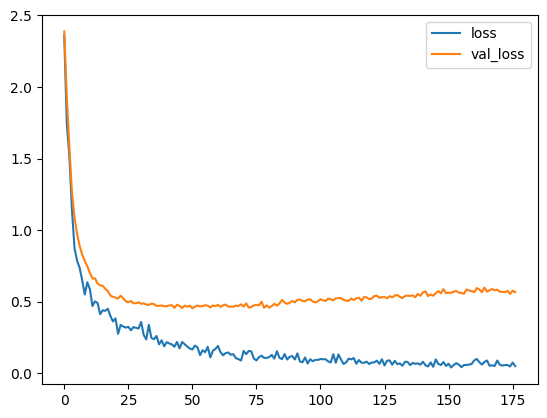

In [26]:
#Overfitting
train_results = pd.DataFrame(transfer_results.history)
train_results.loc[:, ['loss', 'val_loss']].plot()

Ah, it's finally better. The result is still overfitting at about epoch-25. I tried adding image augmentation and random noise to regularize it better, but I think using dropout would be better instead. Nonetheless, the result is okay, but it overfits hard. I need to explore other regularization methods.

###2.2 ConvNeXt Large

In [27]:
#Testing with ConvNeXt Large
convnext_model = keras.applications.ConvNeXtXLarge(
    weights = 'imagenet',
    input_shape = (256, 256, 3),
    include_top = False
)

convnext_model.trainable = False

1393257616/1393257616 [==============================] - 51s 0us/step


In [28]:
#Creating a new model as the new top
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
inputs = keras.Input(input_shape)
random_flip = layers.RandomFlip(seed = 1, input_shape = input_shape)(inputs)
random_rotation = layers.RandomRotation(0.3, seed = 1)(random_flip)
random_zoom = layers.RandomZoom(0.2, seed = 1)(random_rotation)
random_brightness = layers.RandomBrightness(0.1, seed = 1)(random_zoom)
noise = layers.GaussianNoise(seed = 1, stddev = 0.3)(random_brightness)

base = convnext_model(noise, training=False)
pool2D = layers.GlobalAveragePooling2D()(base)
dropout = layers.Dropout(0.5)(pool2D)
outputs = layers.Dense(1)(pool2D)

convnext_transfer_model = keras.Model(inputs, outputs)

In [29]:
convnext_transfer_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss=keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['binary_accuracy'])
convnext_transfer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_brightness_1 (Rando  (None, 256, 256, 3)       0         
 mBrightness)                                                    
                                                                 
 gaussian_noise_1 (Gaussian  (None, 256, 256, 3)       0   

In [30]:
convnext_result = convnext_transfer_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs = 200,
    callbacks = callbacks
)

Epoch 1/200
16/16 [==============================] - 66s 3s/step - loss: 0.3539 - binary_accuracy: 0.8525 - val_loss: 0.0897 - val_binary_accuracy: 0.9869
Epoch 2/200
16/16 [==============================] - 27s 2s/step - loss: 0.0813 - binary_accuracy: 0.9918 - val_loss: 0.0457 - val_binary_accuracy: 0.9869
Epoch 3/200
16/16 [==============================] - 27s 2s/step - loss: 0.0566 - binary_accuracy: 0.9877 - val_loss: 0.0323 - val_binary_accuracy: 0.9869
Epoch 4/200
16/16 [==============================] - 27s 2s/step - loss: 0.0448 - binary_accuracy: 0.9959 - val_loss: 0.0265 - val_binary_accuracy: 0.9869
Epoch 5/200
16/16 [==============================] - 27s 2s/step - loss: 0.0355 - binary_accuracy: 0.9918 - val_loss: 0.0238 - val_binary_accuracy: 0.9869
Epoch 6/200
16/16 [==============================] - 27s 2s/step - loss: 0.0319 - binary_accuracy: 0.9959 - val_loss: 0.0209 - val_binary_accuracy: 0.9869
Epoch 7/200
16/16 [==============================] - 26s 2s/step - los

<Axes: >

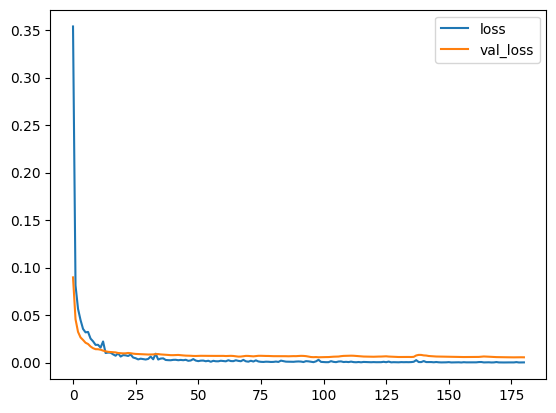

In [31]:
train_results = pd.DataFrame(convnext_result.history)
train_results.loc[:, ['loss', 'val_loss']].plot()

Finally, *chef's kiss*, the model is good! Little overfitting, but not that bad. I would call this a good result (not from my capabilities, but probably just because the pretrained model is good). But the overall result is good.

#3. Testing

In [57]:
#Upload an image here
from google.colab import files
img_files = files.upload()
for file in img_files.keys():
  print(f"{file} of size {len(img_files[file])}")


Saving bees.jpeg to bees (1).jpeg
bees (1).jpeg of size 7748


1/1 [==============================] - 0s 135ms/step
Predicted to be a bee, with approx. [8.613414] from neutrality.


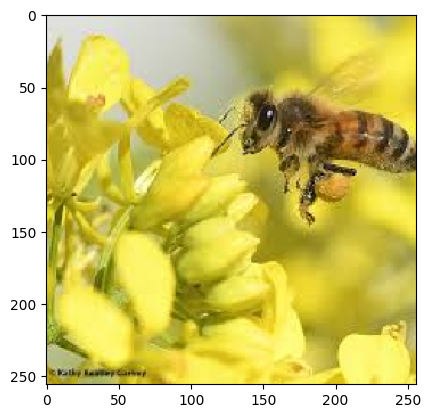

In [58]:
for file in img_files.keys():
  image = tf.keras.utils.load_img(file, target_size = (256, 256), keep_aspect_ratio = True)
  image_arr = np.array(tf.keras.utils.img_to_array(image))
  plt.imshow(image_arr.astype('uint8'))
  image_arr = np.expand_dims(image_arr, axis = 0)

  y_scores = convnext_transfer_model.predict(image_arr, verbose = 1)
  if y_scores[0] < 0.5:
    print(f"Predicted to be an ant, with approx. {abs(y_scores[0])} from neutrality.")
  elif y_scores[0] > 0.5:
    print(f"Predicted to be a bee, with approx. {abs(y_scores[0])} from neutrality.")
  else:
    print(f"Could not gain a confident prediction on the image.")

At the end, there are a few things I learnt.
1. CNN models are trash (GIGO) when the input data is small, and cannot learn much without a proper dataset.
2. Transfer Learning is way better in this case, the CNN model is uncapable to learn much from the small dataset.
3. VGG16 overfits, but the Convnext Large is better at handling it. 

*Additional Note: I tried uploading my face, and it detected me as a bee... so I guess that's an issue :v*